## IMPORT BIBLIOTEK

In [2]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
sns.color_palette('light:b', as_cmap = True)
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
warnings.filterwarnings("ignore")


## ŁADOWANIE DANYCH

In [3]:
df = pd.read_csv('marketing_campaign.csv', sep = '\t')

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## CZYSZCZENIE DANYCH

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Z powyższych informacji możemy wywnioskować, że w kolumnie 'Income' są brakujące dane. Zbiór posiada dane jakościowe, które trzeba będzie zmienić na ilościowe. Kolumna 'Dt_Customer' zawiera daty, które nie są typu DateTime

In [6]:
df = df.dropna()

In [7]:
print("Po usunięciu pustych wpisów zostało " + str(len(df)) + " wierszy.")

Po usunięciu pustych wpisów zostało 2216 wierszy.


Poniżej tworzymy nowe kolumny, które ułatwią dalszą analizę i będą bardziej czytelne dla oka.

In [8]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for date in df['Dt_Customer']:
    date = date.date()
    dates.append(date)

In [9]:
days = []
d1 = max(dates)
for date in dates:
    delta = d1 - date
    days.append(delta)
df['Customer_For'] = days
df['Customer_For'] = pd.to_numeric(df['Customer_For'], errors = 'coerce')

In [10]:
df['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [11]:
df['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [12]:
df["Age"] = 2023-df["Year_Birth"]
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})
df["Children"]=df["Kidhome"]+df["Teenhome"]
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})
df = df.drop(["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"], axis=1)

In [13]:
df.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,83894400000000000,66,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,10800000000000000,69,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,40780800000000000,58,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,5616000000000000,39,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,27734400000000000,42,422,Partner,1,3,1


In [14]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,54.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,27.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,46.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,53.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,64.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,130.000000,2525.000000,3.000000,5.000000,1.000000


Z powyższego opisu wynika, że w danych występują wartości odstające, szczególnie zwrócimy uwagę na wiek i przychody.

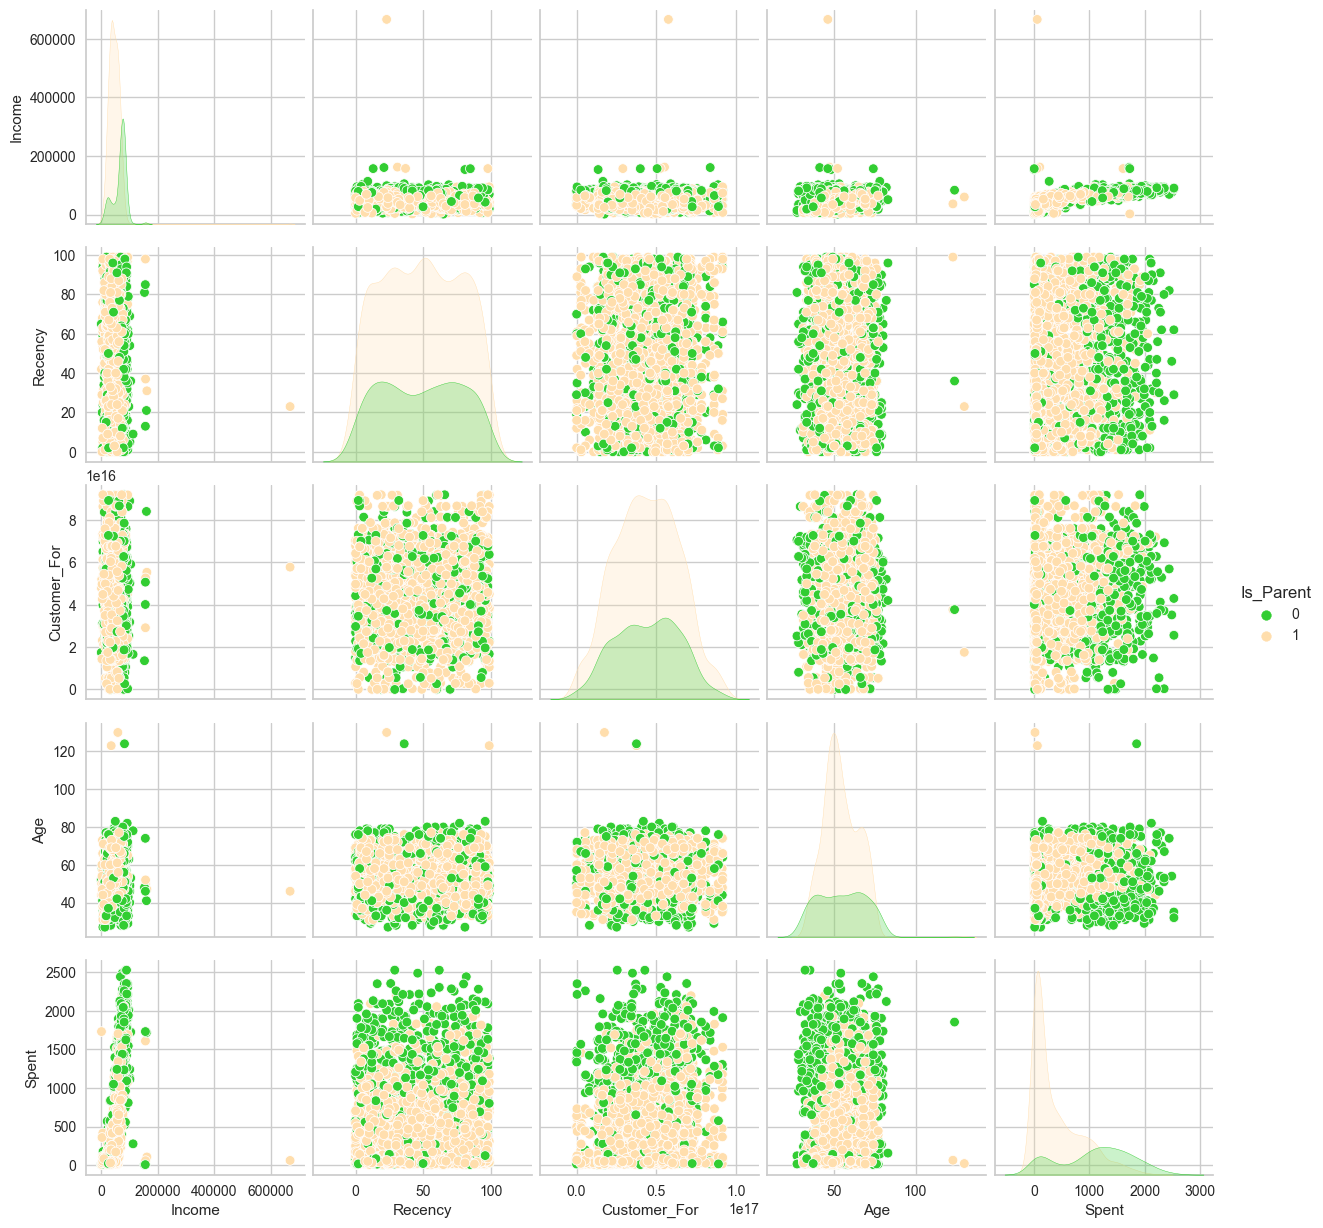

In [15]:
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
sns.pairplot(df[To_Plot], hue = "Is_Parent", palette = (['limegreen', 'navajowhite']));

In [16]:
df = df[(df["Age"] < 100)]
df = df[(df["Income"] < 600000)]

In [17]:
print("Po usunięciu wartości odstających zostało " + str(len(df)) + " wierszy.")

Po usunięciu wartości odstających zostało 2212 wierszy.


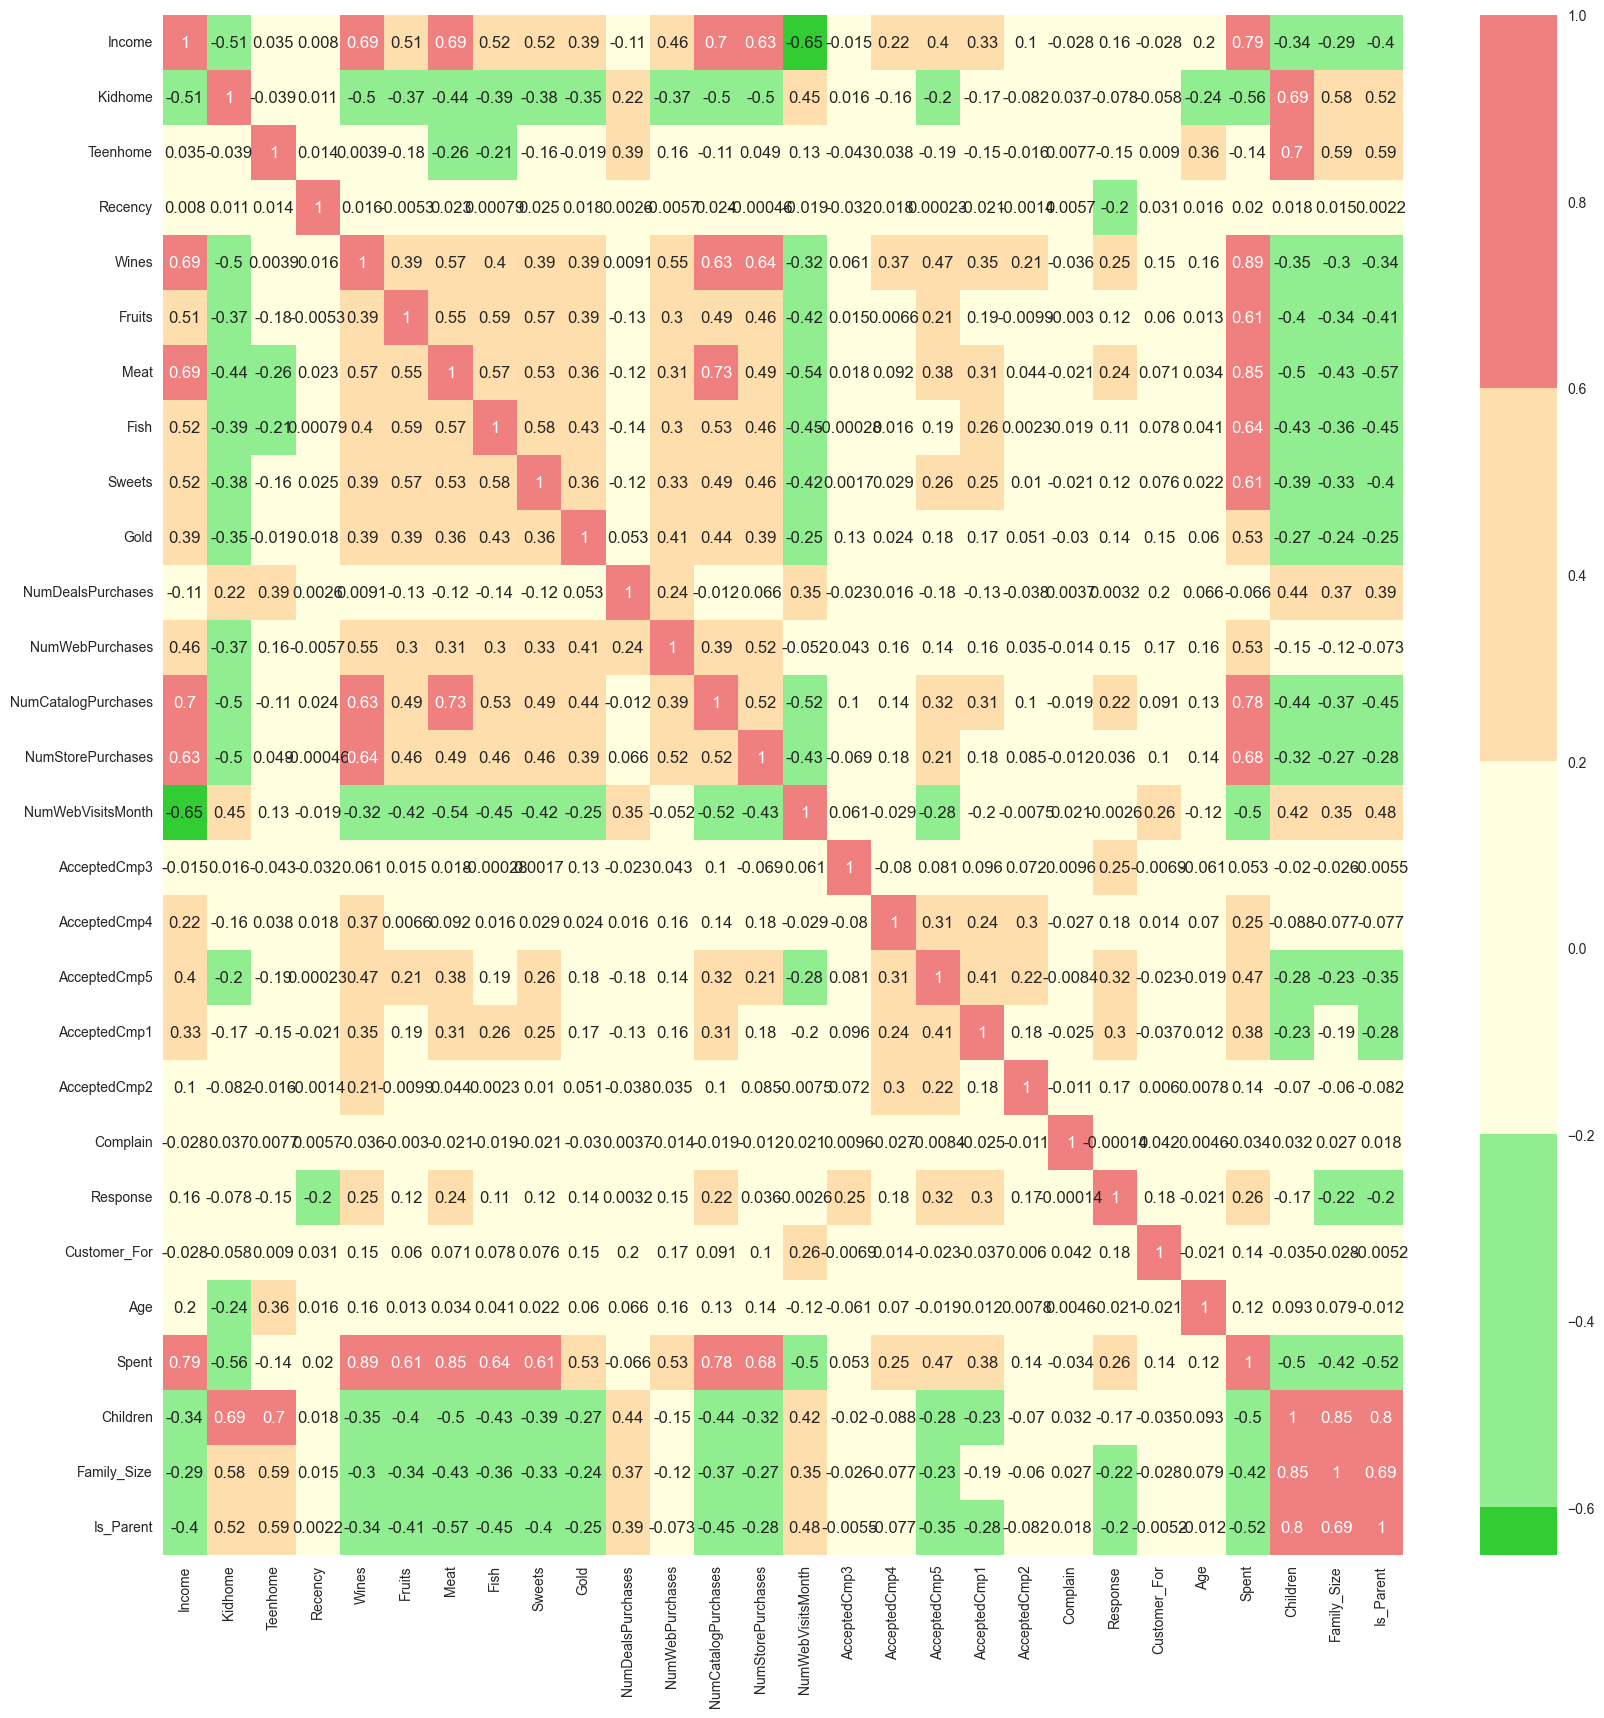

In [18]:
corr = df.corr()
cmap = colors.ListedColormap(["limegreen", 'lightgreen', "lightyellow", "navajowhite", "lightcoral"])
plt.figure(figsize = (20, 20))
sns.heatmap(corr, annot = True, center = 0, cmap = cmap);

## WSTĘPNE PRZETWARZANIE DANYCH

W tej sekcji zajmiemy się 3 rzeczami: zmianą danych jakościowych na ilościowe, skalowaniem danych i przygotowaniem danych do redukcji wymiaru.

In [19]:
LE = LabelEncoder()
df['Education'] = df[['Education']].apply(LE.fit_transform)
df['Living_With'] = df[['Living_With']].apply(LE.fit_transform)

In [20]:
ds = df.copy()
ds =  ds.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response'], axis = 1)
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns = ds.columns)

In [21]:
scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


## REDUKCJA WYMIARU

Z racji, że liczba zmiennych naszych danych jest wysoka, zdecydowaliśmy się na redukcje wymiaru metodą PCA. Analiza składowych głównych pozwala na redukcje ilości zmiennych w taki sposób, by zachować jak największą ilość informacji o danym zjawisku.

In [22]:
pca = PCA(n_components = 20)
pca.fit(scaled_ds)
#pca_ds = pd.DataFrame(pca.transform(scaled_ds), columns = (['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11']))
#pca_ds.describe().T
print(pca.explained_variance_ratio_.sum() * 100)

100.0


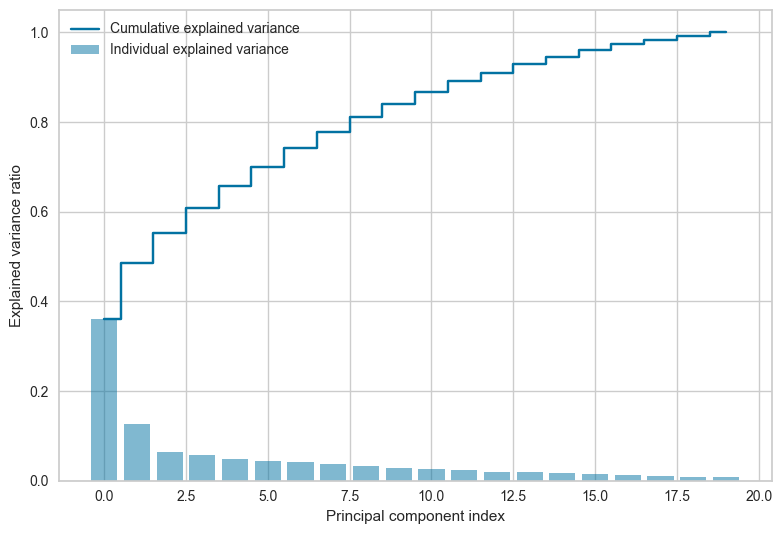

In [23]:
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [24]:
pca = PCA(n_components = 3)
pca.fit(scaled_ds)
pca_ds = pd.DataFrame(pca.transform(scaled_ds), columns = (['col1', 'col2', 'col3']))
pca_ds.describe().T
print(pca.explained_variance_ratio_.sum() * 100)

55.15533937515825


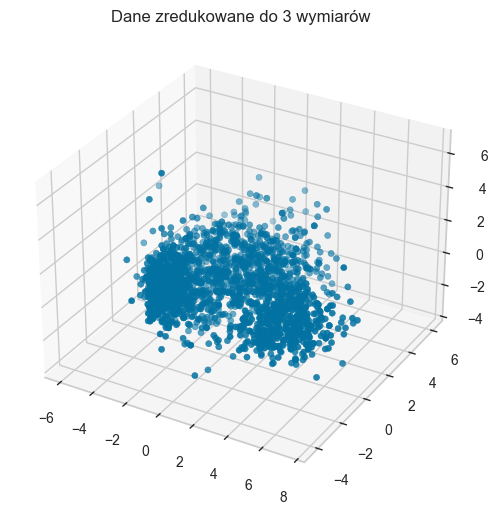

In [25]:
x = pca_ds['col1']
y = pca_ds['col2']
z = pca_ds['col3']

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x, y, z);
ax.set_title("Dane zredukowane do 3 wymiarów")
plt.show()

## KLASTERYZACJA

Aby dowiedzieć się ile klastrów powinniśmy stworzyć, użyliśmy metody łokcia.

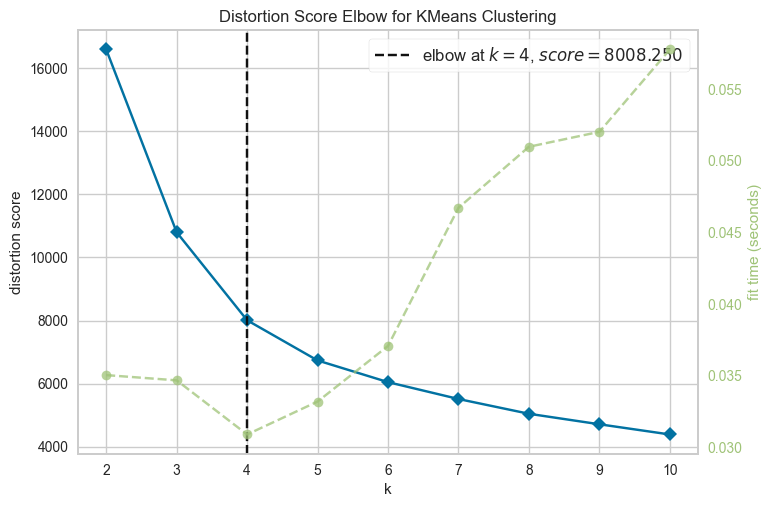

In [37]:
Elbow_M = KElbowVisualizer(KMeans(), k = 10)
Elbow_M.fit(pca_ds)
Elbow_M.show();

In [28]:
AC = AgglomerativeClustering(n_clusters = 4)
pred_AC = AC.fit_predict(pca_ds)
pca_ds['Cluster'] = pred_AC
df['Cluster'] = pred_AC

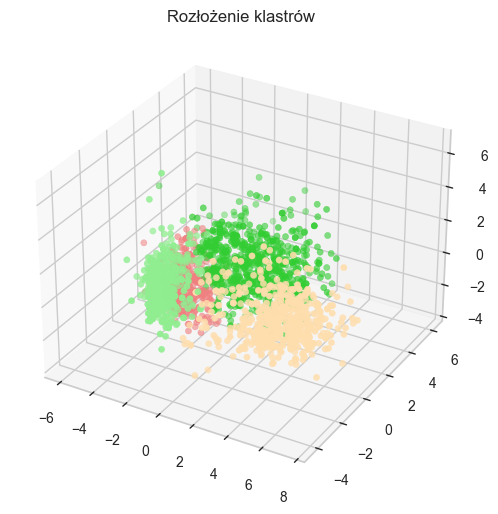

In [29]:
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111, projection = '3d')
ax.scatter(x, y, z, c = pca_ds['Cluster'], cmap = cmap)
ax.set_title("Rozłożenie klastrów")
plt.show()

## 

<AxesSubplot: xlabel='Cluster', ylabel='count'>

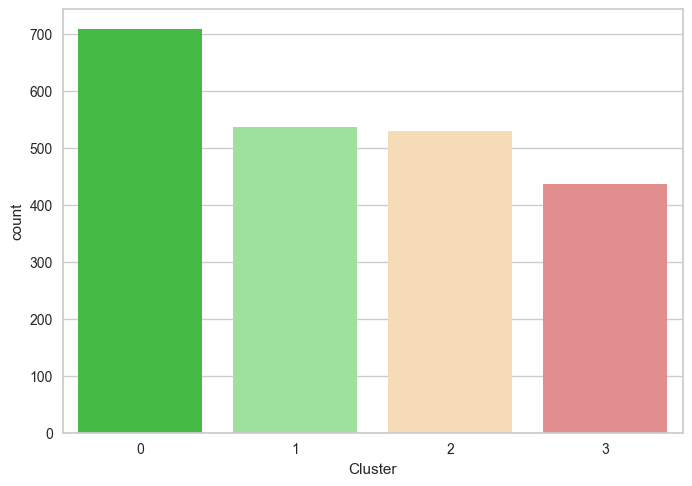

In [30]:
sns.countplot(x = df['Cluster'], palette = ["limegreen", 'lightgreen', "navajowhite", "lightcoral"])

Text(0.5, 1.0, 'Profil klastra na podstawie wydatków i przychodów')

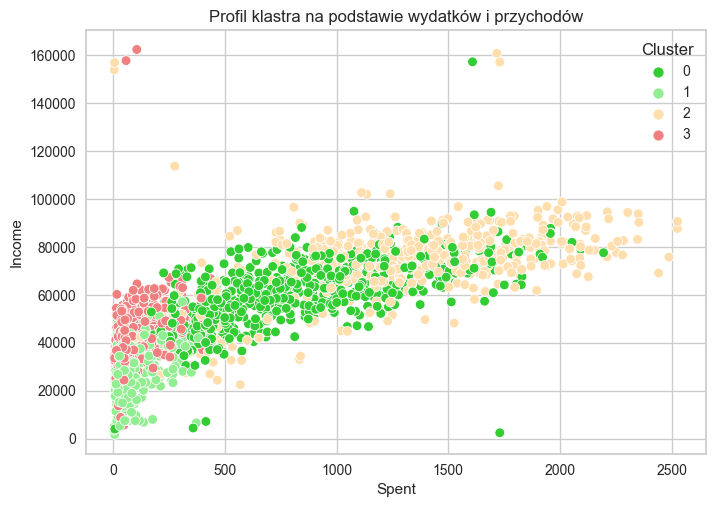

In [31]:
fig = sns.scatterplot(data = df, x = df['Spent'], y = df['Income'], hue = df['Cluster'], palette = ["limegreen", 'lightgreen', "navajowhite", "lightcoral"])
fig.set_title("Profil klastra na podstawie wydatków i przychodów")

Z powżyszego wykresu możemy wyciągnąć następujące wnioski o grupach klientów:<br />
Klaster 0: duże wydatki, średnie przychody<br />
Klaster 1: niskie wydatki, niskie przychody<br />
Klaster 2: wysokie wydatki, wysokie przychody<br />
Klaster 3: niskie wydatkie, średnie przychody

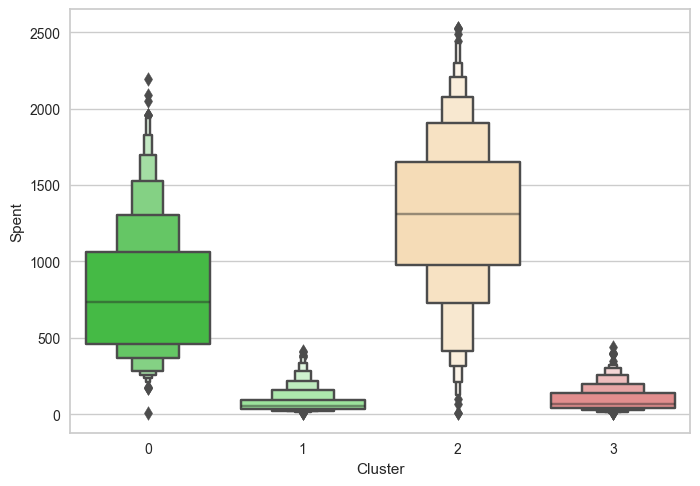

In [32]:
fig = sns.boxenplot(x = df["Cluster"], y = df["Spent"], palette = ["limegreen", 'lightgreen', "navajowhite", "lightcoral"])

Widzimy, że klaster 2 jest naszą główna grupą klientów, a zaraz za nią jest klaster 0.

Kolejnym krokiem jest sprawdzenie efektywności promocji.

Text(0.5, 0, 'Liczba zaakaceptowanych promocji')

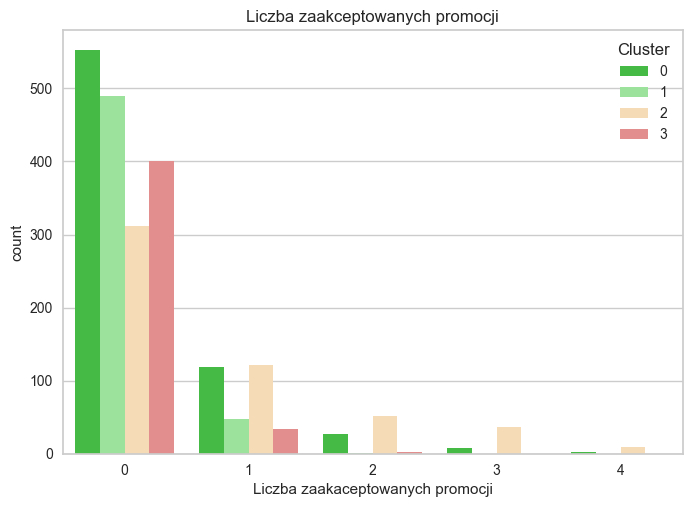

In [33]:
df['Promo'] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
fig = sns.countplot(x = df['Promo'], hue = df['Cluster'], palette = ["limegreen", 'lightgreen', "navajowhite", "lightcoral"])
fig.set_title("Liczba zaakceptowanych promocji")
fig.set_xlabel("Liczba zaakaceptowanych promocji")

Jak widać promocje nie przyciągnęły wielu klientów. Zdecydowana więkoszość nie skorzystała z ani jednej promocji. Można więc uznać, że nie są one efektywne i zastanowić się, co zrobić by przynosiły one oczekiwane skutki, np. personalizowane promocje itd.

Text(0.5, 1.0, 'Liczba zakupionych ofert')

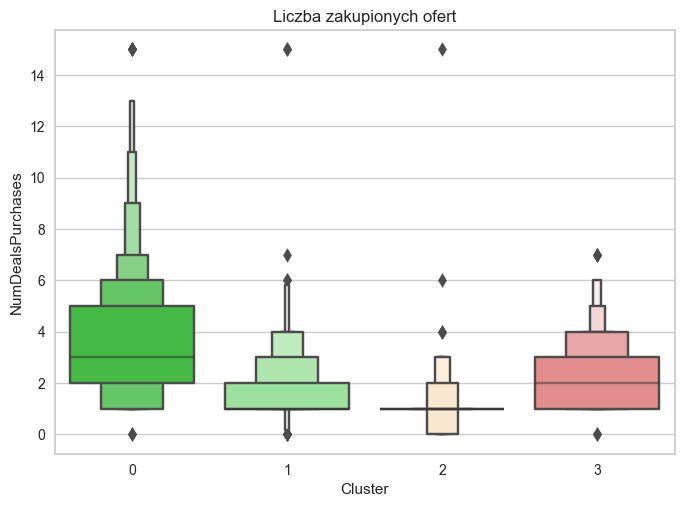

In [34]:
fig = sns.boxenplot(y = df['NumDealsPurchases'], x = df['Cluster'], palette = ["limegreen", 'lightgreen', "navajowhite", "lightcoral"])
fig.set_title("Liczba zakupionych ofert")

Oferty przyniosły lepszy skutek niż promocje. Najwięcej ofert wykorzystały grupy 0 i 3. Klaster 2 nie przywiązywał żadnej wagi do ofert.

## PROFILOWANIE

Mając utworzone klastry i znając ich nawyki konsumpcyjne, będziemy chcieli dowiedzieć się więcej o ich przedstawicielach, aby móc lepiej dopasować oferty i promocje np. oferty dla dzieci, studentów, czy singli.

<Figure size 800x550 with 0 Axes>

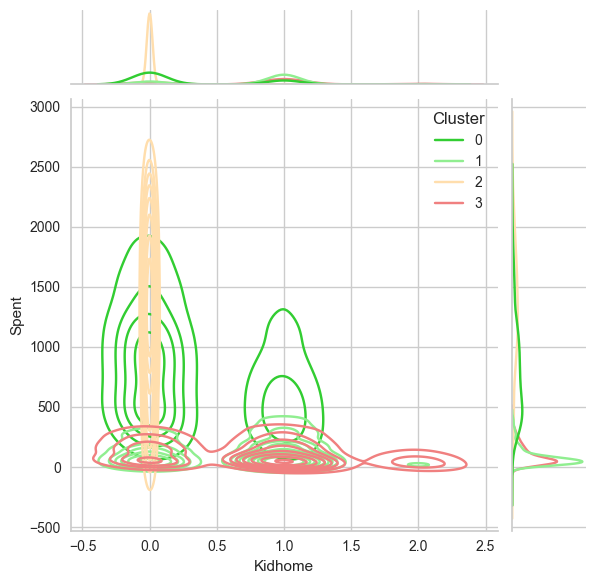

<Figure size 800x550 with 0 Axes>

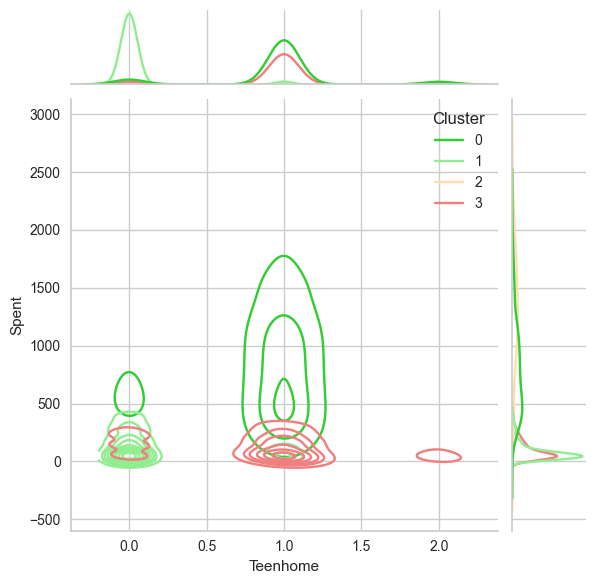

<Figure size 800x550 with 0 Axes>

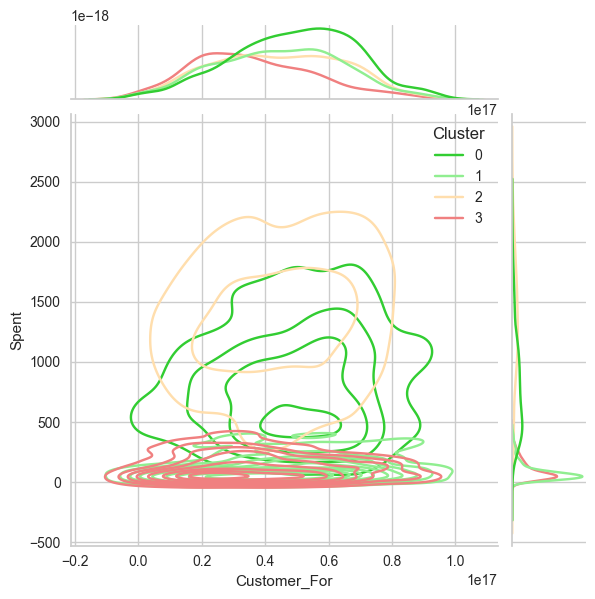

<Figure size 800x550 with 0 Axes>

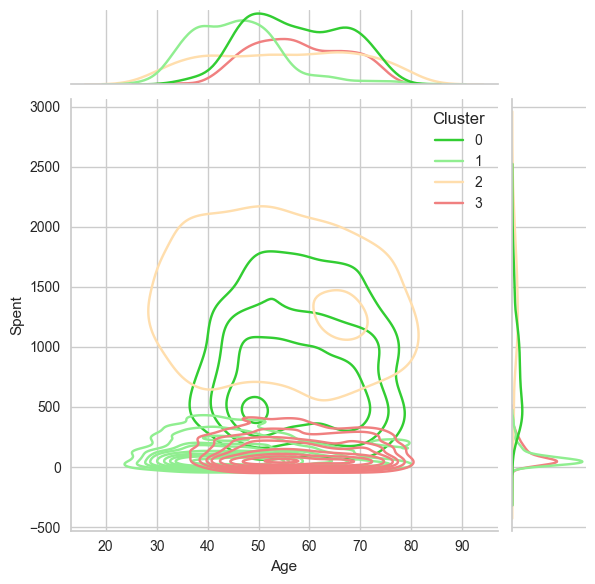

<Figure size 800x550 with 0 Axes>

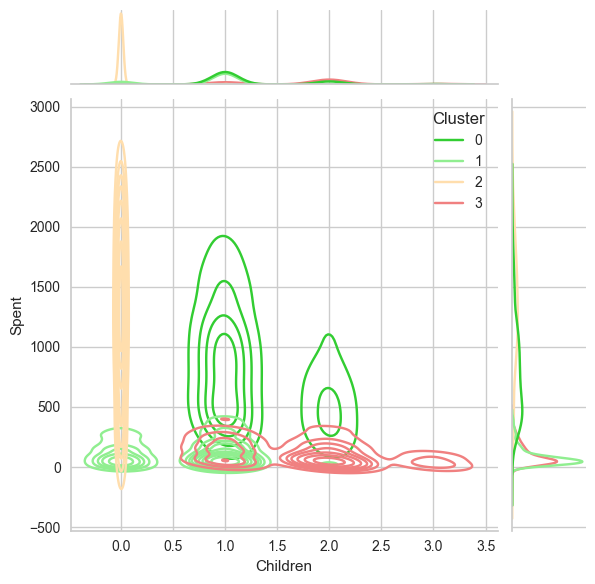

<Figure size 800x550 with 0 Axes>

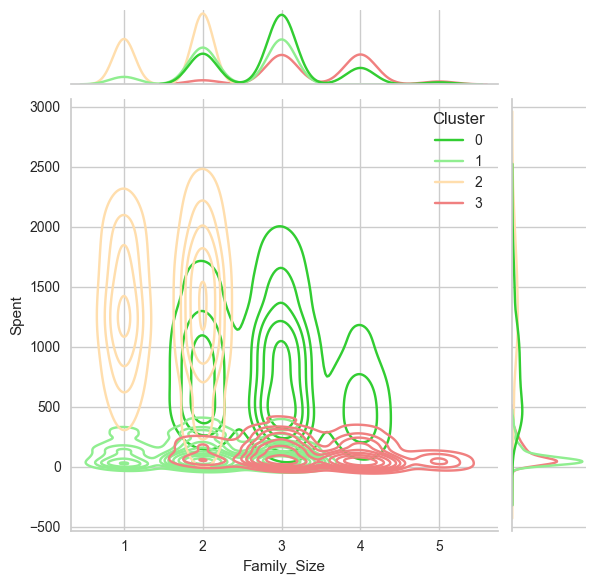

<Figure size 800x550 with 0 Axes>

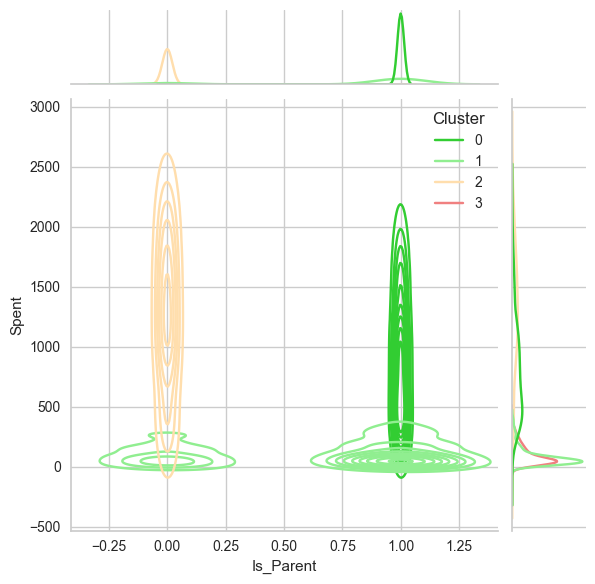

<Figure size 800x550 with 0 Axes>

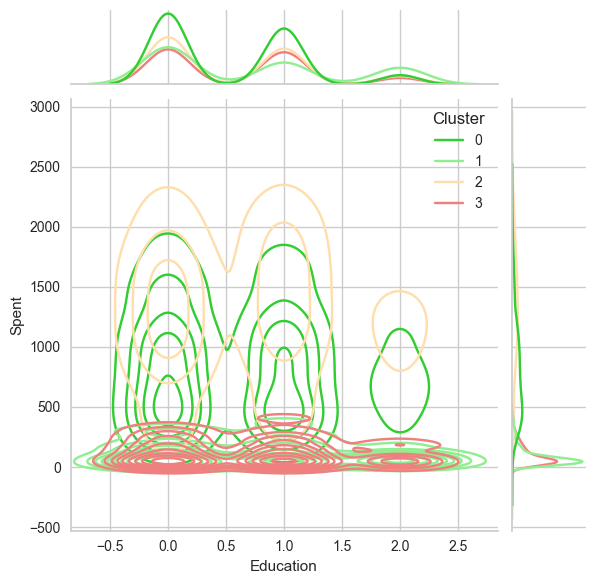

<Figure size 800x550 with 0 Axes>

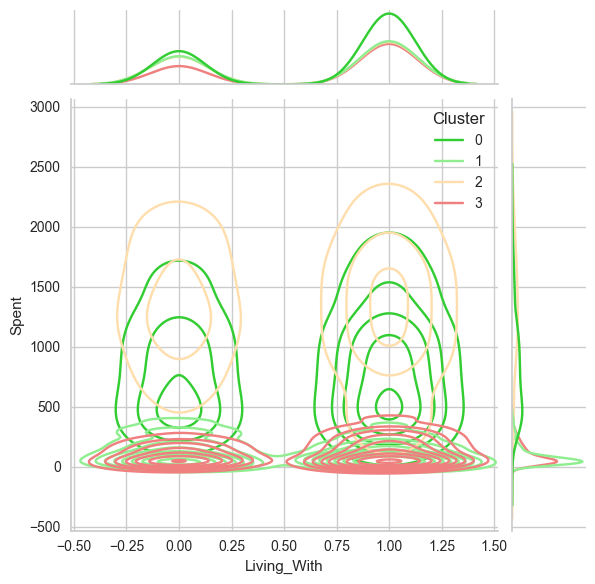

In [35]:
Personal_data = ["Kidhome",  "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]
for i in Personal_data:
    plt.figure()
    sns.jointplot(x = df[i], y = df['Spent'], hue = df['Cluster'], kind = 'kde', palette = ["limegreen", 'lightgreen', "navajowhite", "lightcoral"])

## WNIOSKI

Z powyższych wykresów można stworzyć prosty opis przeciętnego przedstawiciela danego klastra

Klaster 0: <br />
- Jest rodzicem<br />
- Między 2, a 4 osoby w gospodarstwie domowym<br />
- Większkość ma nastoletnie dziecko <br />
- Stosunkowo stara grupa <br />
- Samotni rodzice są podgrupą

Klaster 1: <br />
- Większość jest rodzicem <br />
- Maks. 3 osoby w gospodarstwie domowym <br />
- Większość ma 1 dziecko, zwykle nie jest to nastolatek <br />
- Stosunkowo młoda grupa


Klaster 2: <br />
- Nie jest rodzicem <br />
- Maks. 2 osoby w gospodarstwie domowym <br />
- Wszystkie grupy wiekowe <br />
- Zamożna grupa

Klaster 3: <br />
- Jest rodzicem <br />
- Między 2, a 5 osób w gospodarstwie domowym <br />
- Stosunkowo niskie przychody <br />
- Stosunkowo stara grupa <br />
- Więkoszość ma w domu nastolatka